In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import ipyvolume as ipv
from ipywidgets import FloatProgress
from IPython.display import display, Image

from tyssue import HistoryHdf5, EventManager

from tyssue.draw import sheet_view, browse_history
from tyssue.geometry.bulk_geometry import ClosedMonolayerGeometry as geom
from tyssue.io import hdf5
from tyssue.dynamics import model_factory, effectors
from tyssue.generation.shapes import spherical_monolayer

from tyssue.behaviors import EventManager
from tyssue.behaviors import increase, decrease, reconnect
from tyssue.solvers.viscous import EulerSolver
from tyssue.utils.decorators import face_lookup


from tyssue.draw import highlight_faces, create_gif
from tyssue.solvers.quasistatic import QSSolver


from tyssue import HistoryHdf5



from pathlib import Path

from tyssue.utils.decorators import cell_lookup
from tyssue.topology.monolayer_topology import cell_division


Reference: https://elifesciences.org/articles/32943


It is conveninent to consider that cells have an average volume of 1


| stade  | nombe de cellules | volume interne (μm3) |
| ------ | --------- | ---------- |
| 3 | 120 | 181008 |
| 4 | 200 | 670400 |
| 5 | 400 | 3352000 | 
| 6 | 700 | 12318600 | 

## Experimental data

In [2]:
growth = pd.DataFrame(
    data=[[12, 181000], [200, 670400], [400, 3352000], [700, 12318600]],
    index=pd.Index([3, 4, 5, 6], name='stage'),
    columns=['Nc', 'lumen_vol']
)
growth

,Nc,lumen_vol
stage,,
3,12,181000
4,200,670400
5,400,3352000
6,700,12318600


$$
\ln(V_\mathrm{lum})(t) = a + k_V t\\
V_\mathrm{lum}(t) = V_0 e^{k_V t}
$$



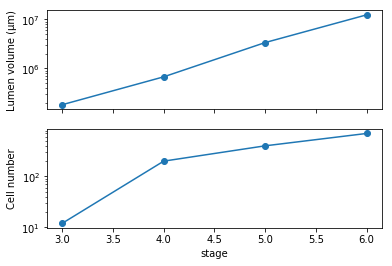

In [3]:
fig, (ax_v, ax_c) = plt.subplots(2, sharex=True)

ax_v.plot(growth.lumen_vol, '-o')
ax_v.set_yscale('log')
ax_v.set_ylabel('Lumen volume (µm)')

ax_c.plot(growth.Nc, '-o')
ax_c.set_yscale('log')
ax_c.set_ylabel('Cell number')
_ = ax_c.set_xlabel("stage")


In [4]:
kV, lnV0 = np.polyfit(growth.index, np.log(growth.lumen_vol), 1)

print(f"Lumen volume growth rate: {kV:.2f}")

kD, lnc0 = np.polyfit(growth.index, np.log(growth.Nc), 1)

print(f"Division rate: {kD:.2f}")


Lumen volume growth rate: 1.43
Division rate: 1.29


## Follicle monolayer creation


In [6]:
follicle = spherical_monolayer(9., 12., 200, apical='in')
follicle.settings["lumen_side"] = "apical"
geom.update_all(follicle)
geom.scale(follicle, follicle.cell_df.vol.mean()**(-1/3), list("xyz"))
geom.update_all(follicle)

for df in follicle.datasets.values():
    df.dropna(axis=1, how='any', inplace=True)

print(f"Follicle has {follicle.Nc} cells")

Follicle has 203 cells


In [7]:
print(follicle.settings)

{'lumen_side': 'apical', 'lumen_vol': 150.52864922182738}


In [8]:
draw_specs = {
    'edge': {
        'visible': False,
    },
    'face': {
        'visible': True,
        'color': lambda sheet: sheet.face_df['area']
    },
}


In [9]:
ipv.clear()
follicle.face_df['visible'] = (follicle.face_df['y'] > 0) | (follicle.face_df['x'] > 0)
fig, mesh = sheet_view(follicle, mode="3D", **draw_specs)
fig

/home/guillaume/miniconda3/envs/tyssue/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [10]:
bck0 = follicle.copy()

In [11]:
follicle = bck0.copy()

model = model_factory([
    effectors.LumenVolumeElasticity,
    effectors.FaceAreaElasticity,
    effectors.PerimeterElasticity,
    effectors.CellVolumeElasticity,
    effectors.CellAreaElasticity,
    ])



specs = {
    'cell': {
        'is_alive': 1,
        'area_elasticity': 0.1,
        'prefered_area': follicle.cell_df.area.mean()*0.8,
        'vol_elasticity': 1.0,
        'prefered_vol': 1.0
    },
    'face': {
        'is_alive': 1,
        'area_elasticity': 1.0,
        'prefered_area': 1.0,
        'perimeter_elasticity': 0.1,
        'prefered_perimeter': 3.81,
    },
    'settings': {
        'lumen_vol_elasticity': 1./ follicle.Nc,
        'lumen_prefered_vol': follicle.settings['lumen_vol'],
    }
}

follicle.update_specs(specs, reset=True)

follicle.face_df.loc[follicle.basal_faces, 'perimeter_elasticity'] = 0.0
follicle.face_df.loc[follicle.basal_faces, 'area_elasticity'] = 0
follicle.face_df.loc[follicle.lateral_faces, 'perimeter_elasticity'] = 0.0
follicle.face_df.loc[follicle.lateral_faces, 'area_elasticity'] = 0

A0 = follicle.face_df.loc[follicle.apical_faces, 'area'].mean()
follicle.face_df.loc[follicle.apical_faces, 'prefered_area'] = A0
follicle.face_df.loc[follicle.apical_faces, 'prefered_perimeter'] = 3.81 * A0**0.5



Reseting column is_alive of the cell dataset with new specs
Reseting column is_alive of the face dataset with new specs


In [12]:
solver = QSSolver()
res = solver.find_energy_min(follicle, geom, model)
print(res.message)



b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


In [13]:
ipv.clear()
follicle.face_df['visible'] = (
    (
        (follicle.face_df['y'] > 0)
        | (follicle.face_df['x'] > 0)
    )
    #& (follicle.face_df['segment'] == "apical")
)
# follicle.face_df['visible'] = True
fig, mesh = sheet_view(follicle, mode="3D", **draw_specs)
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [14]:
def contractility_grad_along_z(z, z_a=10, ant_increase=6, post_increase=6):
    """Returns the amplitude of the gradient for z 
    (along the posterior-anterior axis of the follicle).
    
    The gradient is modeled as a quadratic function of z, such that the increase in
    contractility is equal to ant_increase at z_a and to post_increase at -z_a.
    
    """
    
    # we look for a quadradic function with C(-z_a) = ant_increase, C(z_a) = post_increase
    # and C(z_min) = 0 - we find the correct coefs p2, p1 and p0 bellow
    
    app = ant_increase + post_increase
    amp = ant_increase - post_increase
    if amp == 0.:
        p2 = ant_increase / z_a**2
        p1 = 0
        p0 = 0
    else:
        p1 = amp / (2 * z_a)
        inv_poly = [2*z_a**2, -app, p1**2]
        p2_0, p2_1 = np.poly1d(inv_poly).roots
        if isinstance(p2_0, np.complex):
            p2_0, p2_1 = np.real([p2_0, p2_1])
        p2 = p2_0 if p2_0 >= 0 else p2_1
        p0 = p1**2 / (4*p2)

    poly = np.poly1d([p2, p1, p0])
    return np.polyval(poly, z)

def contractility_grad(follicle, cell, amp, span, coords=['x', 'y', 'z']):
    
    cell_pos = follicle.cell_df.loc[cell, coords].to_numpy()
    distance = np.linalg.norm(
        follicle.face_df[coords] - cell_pos[None, :],
        axis=1)
    
    grad = amp * np.exp(-distance / span)
    return grad - grad.min()


In [15]:
bck1 = follicle.copy()

## Static contractility gradient

In [81]:
follicle = bck1.copy()

anterior_cell = follicle.cell_df['z'].idxmin() 
posterior_cell = follicle.cell_df['z'].idxmax() 

follicle.face_df["contractile_grad"] = 1 + (
    contractility_grad(follicle, anterior_cell, amp=6, span=1)
    + contractility_grad(follicle, posterior_cell, amp=6, span=1)
)

follicle.face_df["prefered_area"] /= follicle.face_df["contractile_grad"]
follicle.face_df["prefered_perimeter"] /= follicle.face_df["contractile_grad"]**0.5


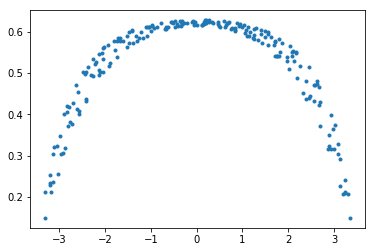

In [82]:
fig, ax = plt.subplots()
ax.plot(
    follicle.face_df.loc[follicle.apical_faces, 'z'],
    follicle.face_df.loc[follicle.apical_faces, 'prefered_area'], '.')

In [83]:
draw_specs = {
    'edge': {
        'visible': False,
    },
    'face': {
        'visible': True,
        'color': lambda sheet: sheet.face_df['contractile_grad']
    },
}


In [84]:
solver = QSSolver()
res = solver.find_energy_min(follicle, geom, model)
print(res.message)


b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


In [85]:

ipv.clear()

fig, mesh = sheet_view(follicle, mode="3D", **draw_specs)
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

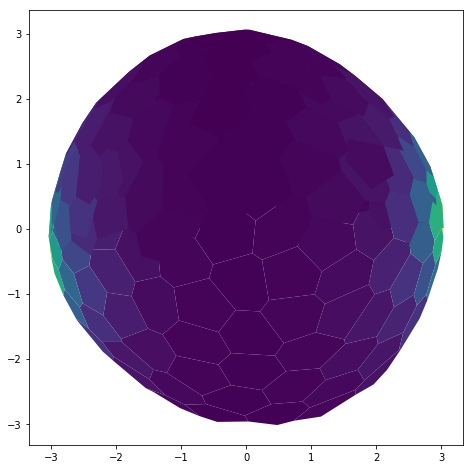

In [86]:
fig, ax = sheet_view(follicle.get_sub_sheet('apical'), mode="2D", coords=["z", "x"], **draw_specs)
fig.set_size_inches(8, 8)

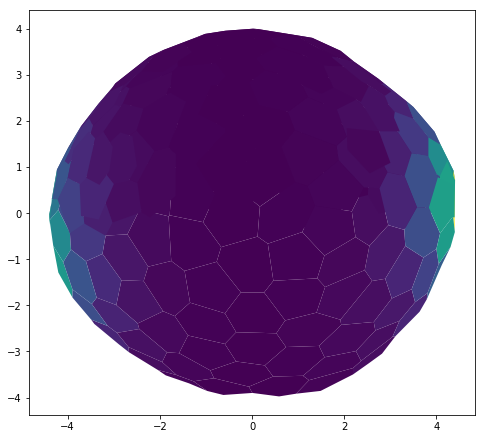

In [87]:
basal_s = follicle.get_sub_sheet('basal')
basal_s.reset_index()
fig, ax = sheet_view(basal_s, mode="2D", coords=["z", "x"], **draw_specs)
fig.set_size_inches(8, 8)


### Increasing lumen volume





In [18]:
follicle.settings['lumen_prefered_vol'] = 2.


In [20]:
solver = QSSolver()
res = solver.find_energy_min(follicle, geom, model)
print(res.message)


b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


In [21]:

ipv.clear()

fig, mesh = sheet_view(follicle, mode="3D", **draw_specs)
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

## Cell division and dynamic model

$$
\ln(V_\mathrm{lum})(t) = a + k_V t\\
V_\mathrm{lum}(t) = V_0 e^{k_V t}
$$



In [36]:
### follicle = bck1

# We take the time unit as 1/100th of a development stage

dt = 1e-2

default_division_spec = {
    "cell": -1,
    "growth_rate": 0.014,
    "critical_vol": 2.,
    "autonomous": True,
}

follicle.update_specs(
    {'settings':
     {
        "threshold_length": 1e-1,  # Critical length to trigger rearangements
        "p_4": 1.,  ## Frequency of rearangements
        "p_5+": 0.1,
    },
    'vert': {
        "viscosity": 0.1
    },
    'edge': {
        'is_valid': 1,
    }
})



# This will go in tyssue in the next release
@cell_lookup
def division(mono, manager, **kwargs):
    """Cell division happens through cell growth up to a critical volume,
    followed by actual division of the cell.
    
    Parameters
    ----------
    mono : a `Monolayer` instance
    manager : an `EventManager` instance
    cell_id : int,
      index of the mother cell
    growth_rate : float, default 0.1
      rate of increase of the prefered volume
    critical_vol : float, default 2.
      volume at which the cells stops to grow and devides
    """
    division_spec = default_division_spec
    division_spec.update(**kwargs)

    cell = division_spec["cell"]
    Vc = division_spec["critical_vol"] * mono.specs["cell"]["prefered_vol"]
    if mono.cell_df.loc[cell, "vol"] < Vc:
        dv = 1+division_spec["growth_rate"]*mono.settings['dt']
        da = dv**(1/3)
        increase(
            mono,
            'cell',
            cell,
            dv,
            "prefered_vol"
        )
        increase(
            mono,
            'cell',
            cell,
            1+da,
            "prefered_area"
        )
        manager.append(division, **division_spec)
    else:
        print(f'division of cell {cell}')
        mono.cell_df.loc[cell, "prefered_vol"] = mono.specs["cell"]["prefered_vol"]
        daughter = cell_division(mono, cell, 'vertical')
        daughter_id = mono.cell_df.id.max() + 1
        mono.cell_df.loc[daughter, "id"] = daughter_id
        if division_spec["autonomous"]:
            manager.append(division, **division_spec)
            division_spec['cell_id'] = daughter_id
            manager.append(division, **division_spec)
            
            
def lumen_growth(mono, manager, **kwargs):
    
    growth_rate = 0.02# kwargs.get('growth_rate', 0.014)
    dt = mono.settings["dt"]
    mono.settings['lumen_prefered_vol'] *= 1 + growth_rate*dt
    manager.append(lumen_growth, **kwargs)
    

base_dir = Path("../data")
time_stamp = datetime.today().strftime("%y-%m-%d-%H-%M-%S")
history_file = Path(f"hist2D_{time_stamp}.hf5")


follicle.cell_df['id'] = follicle.cell_df.index.copy()

# Copy the initial follicle
eptm = follicle.copy()


eptm.settings["dt"] = dt

manager = EventManager("cell")
# Auto solve rearangements
#manager.append(reconnect)

for cell_id in eptm.cell_df['id']:
    manager.append(division, cell_id=cell_id)

manager.append(lumen_growth, growth_rate=1.4e-2)


history = HistoryHdf5(
    eptm,
    save_every=0.1,
    dt=dt,
    hf5file=base_dir / history_file,
    extra_cols={
        elem: list(follicle.datasets[elem].columns) for elem in follicle.datasets
    },  # record everything
)

solver = EulerSolver(
    eptm,
    geom,
    model,
    manager=manager,
    history=history,
    bounds=(
        -eptm.edge_df.length.median() / 10.0,
        eptm.edge_df.length.median() / 10.0,
    ),
)

manager.update()


In [37]:
print(eptm.settings['lumen_prefered_vol'])

150.52864922182738


In [40]:
solver.solve(100, dt)
print(eptm.settings['lumen_prefered_vol'])

division of cell 102
division of cell 150
division of cell 110
division of cell 2
division of cell 129
division of cell 65
division of cell 160
division of cell 173
division of cell 49
division of cell 144
division of cell 138
division of cell 157
division of cell 187
division of cell 193
division of cell 79
division of cell 40
division of cell 159
division of cell 27
division of cell 71
division of cell 62
division of cell 32
division of cell 61
division of cell 73
division of cell 46
division of cell 9
division of cell 25
division of cell 76
division of cell 59
division of cell 70
division of cell 77
division of cell 189
division of cell 147
division of cell 67
division of cell 164
division of cell 42
division of cell 126
division of cell 105
division of cell 195
division of cell 14
division of cell 158
division of cell 97
division of cell 38
division of cell 120
division of cell 23
division of cell 21
division of cell 124
division of cell 115
division of cell 56
division of cell 41


ValueError: not enough values to unpack (expected 1, got 0)

In [41]:
browse_history(solver.history, **draw_specs)

/home/guillaume/miniconda3/envs/tyssue/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


interactive(children=(IntSlider(value=0, description='i', max=64), Output()), _dom_classes=('widget-interact',…

In [42]:
QSSolver().find_energy_min(eptm, geom, model)

/home/guillaume/miniconda3/envs/tyssue/lib/python3.7/site-packages/tyssue-0.7.0-py3.7-linux-x86_64.egg/tyssue/geometry/bulk_geometry.py:106: RuntimeWarning: divide by zero encountered in true_divide
  weighted_pos.values / eptm.face_df["perimeter"].values[:, np.newaxis]
/home/guillaume/miniconda3/envs/tyssue/lib/python3.7/site-packages/tyssue-0.7.0-py3.7-linux-x86_64.egg/tyssue/geometry/bulk_geometry.py:106: RuntimeWarning: invalid value encountered in true_divide
  weighted_pos.values / eptm.face_df["perimeter"].values[:, np.newaxis]


      fun: nan
 hess_inv: <4164x4164 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.71583968e+195, -1.47734766e+195, -9.78516269e+194, ...,
        1.45742573e+195, -4.04651409e+194,  4.71696539e+194])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 21
      nit: 0
   status: 2
  success: False
        x: array([-1.03922077, -1.90419839, -1.96047451, ..., -4.32001538,
       -1.41726674, -1.75277538])